Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Classification using Automated ML

In this example we use Azure ML's Automated ML functionality to improve on the classifier we built earlier. Automated ML handles the task of building many models from a wide variety of algorithms and choosing a good set of hyper-parameters for them. We then select best model (or one that meets our criteria) and deploy it as a web service.

## Load and prepare experiment

As part of the setup we have already created an AML workspace. Let's load the workspace and create an experiment.

In [12]:
import json
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

We load the workspace directly from the config file we created in the early part of the course.

In [13]:
config_path = '../lab02.0_PdM_Setting_Up_Env/aml_config/config.json'
ws = Workspace.from_config(config_path)

experiment_name =  'pred-maint-automl' # choose a name for experiment
project_folder = '.' # project folder

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: /data/home/dsvmuser/LearnAI-ADPM/lab02.0_PdM_Setting_Up_Env/aml_config/config.json


,
SDK version,0.1.74
Subscription ID,507d3cfb-2fe3-47d6-8366-5e5cfed2dc8e
Workspace,amitworkspace
Resource Group,ODL-ai-detect-anomalies-40451-01
Location,southcentralus
Project Directory,.
Experiment Name,pred-maint-automl


Opt in for diagnostics for better experience, quality, and security of future releases:

In [14]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics=True)

## Instantiate config file

We now instantiate a `AutoMLConfig` object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize.<br> Classification supports the following primary metrics <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>balanced_accuracy</i><br><i>average_precision_score_weighted</i><br><i>precision_score_weighted</i>|
|**max_time_sec**|Time limit in seconds for each iterations|
|**iterations**|Number of iterations. In each iteration Auto ML trains the data with a specific pipeline|
|**n_cross_validations**|Number of cross validation splits|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification.  This should be an array of integers. |
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. |

In [15]:
%%bash

# you might have to uncomment the next line if you get a CommandNotFoundError
 . /anaconda/etc/profile.d/conda.sh

conda activate py36 # if you just run activate you get permission denied



pip install --upgrade pip
pip install --upgrade azureml-sdk[automl,notebooks] # I had to run it twice before it worked

Requirement already up-to-date: pip in /data/anaconda/envs/py36/lib/python3.6/site-packages (18.1)
Requirement already up-to-date: azureml-sdk[automl,notebooks] in /data/anaconda/envs/py36/lib/python3.6/site-packages (0.1.74)


In [16]:
import azureml.core

print("SDK Version:", azureml.core.VERSION)

SDK Version: 0.1.74


In [17]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

In [18]:
X_train.head()

,volt_ma_3,rotate_ma_3,pressure_ma_3,vibration_ma_3,volt_sd_3,rotate_sd_3,pressure_sd_3,vibration_sd_3,volt_ma_12,rotate_ma_12,...,m_4,dm_1,dm_2,dm_3,dm_4,df_1,df_2,df_3,df_4,age
0,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,166.967614,429.934546,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18
1,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,166.967614,429.934546,...,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,18
2,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,166.967614,429.934546,...,0.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,18
3,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,166.967614,429.934546,...,0.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,18
4,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,166.662702,426.828877,...,0.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,18


In [19]:
y_train.head()

,y_1,y_2,y_3,y_4
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


Here are the metrics we can choose to optimize our model over.

In [20]:
azureml.train.automl.constants.Metric.CLASSIFICATION_PRIMARY_SET

{'AUC_weighted',
 'accuracy',
 'average_precision_score_weighted',
 'balanced_accuracy',
 'precision_score_weighted'}

We now set up a configuration file for the automated ML training experiment. It contains details for how the experiment should run.

In [21]:
automl_config = AutoMLConfig(task='classification', 
                             preprocess=False,
                             name=experiment_name,
                             debug_log='automl_errors.log',
                             primary_metric='AUC_weighted',
                             max_time_sec=1200,
                             iterations=2,
                             n_cross_validations=2,
                             verbosity=logging.INFO,
                             X = X_train.values, # we convert from pandas to numpy arrays using .vaules
                             y = y_train.values[:, 0], # we convert from pandas to numpy arrays using .vaules
                             path=project_folder)

## Run training experiment

You can call the submit method on the experiment object and pass the run configuration. For Local runs the execution is synchronous. Depending on the data and number of iterations this can run for while.
You will see the currently running iterations printing to the console.

In [22]:
local_run = experiment.submit(automl_config, show_output=True)

Parent Run ID: AutoML_a03293e1-66be-4d2e-8960-6d89f51dcef6
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      StandardScalerWrapper LogisticRegressi0:00:25.376682           0.969     0.969
         1      MaxAbsScaler LightGBMClassifier       0:01:12.869259           0.993     0.993


## Retrieve the Best Model

Below we select the best pipeline from our iterations. The *get_output* method on automl_classifier returns the best run and the fitted model for the last *fit* invocation. There are overloads on *get_output* that allow you to retrieve the best run and fitted model for *any* logged metric or a particular *iteration*.

In [23]:
best_run, fitted_model = local_run.get_output()

In [24]:
fitted_model

Pipeline(memory=None,
     steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7fa7c8753c88>)])

We can see from the above results that `StandardScalerWrapper` was used to scale the features and a `LightGBMClassifier` was chosen as the best model based on the metric we defined. This of course does NOT automatically also make it the best model in production, but choosing the right model for production is beyond the scope of this course so we will not address it here.

### Hands-on lab

<div class="alert alert-info">
Uncomment and run the following cell and go to the link provided under Details Page. This links will take us to the Azure portal. Examine the content of the page. Can you find what resource group this resource is under? What kind of resource is it?
</div>

In [25]:
 best_run

Experiment,Id,Type,Status,Details Page,Docs Page
pred-maint-automl,AutoML_a03293e1-66be-4d2e-8960-6d89f51dcef6_1,,Completed,Link to Azure Portal,Link to Documentation


<div class="alert alert-info">
In addition to choosing a good algorithm, the experiment also tuned hyper-parameters. So our model didn't just run with the default hyper-parameter values. Find out how we can get the chosen hyper-parameters from the `fitted_model` object. Describe the hyper-parameters you see. Which ones do you think are the most critical ones?
</div>

In [26]:
fitted_model

Pipeline(memory=None,
     steps=[('MaxAbsScaler', MaxAbsScaler(copy=True)), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7fa7c8753c88>)])

### End of lab

## Manually train selected model (optional - only as a sanity check)

With the following Python snippet, we can take the information above and store the hyper-parameters for the chosen scaler and chosen model into separate dictionaries we call `scaler_params` and `model_params`.

In [27]:
import re

params = re.findall(r"StandardScalerWrapper__\w+", " ".join(fitted_model.get_params().keys()))
vals = [fitted_model.get_params()[k] for k in params]
keys = [re.split("__", p)[1] for p in params]

scaler_params = {k:v for k,v in zip(keys, vals)}

params = re.findall(r"LightGBMClassifier__\w+", " ".join(fitted_model.get_params().keys()))
vals = [fitted_model.get_params()[k] for k in params]
keys = [re.split("__", p)[1] for p in params]

model_params = {k:v for k,v in zip(keys, vals)}

### Hands-on lab

<div class="alert alert-info">
Let's now re-create the model that we found above by passing the parameters directly to the scaler and the algorithm. We already have our model, so there's no need to do this other than as a sanity check. Train a `LightGBMClassifier` (using `model_params`) after using `StandardScaler` (with `scaler_params`) to rescale the data. You can do both in a single line of code by using `Pipeline`. Please add your code to the chunk below:
</div>

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from azureml.train.automl.model_wrappers import LightGBMClassifier

## YOUR CODE GOES HERE (manual_model = Pipeline(...))

## YOUR CODE GOES HERE (train the model on the data)
## YOUR CODE GOES HERE (score the test data with the trained model)

In [29]:
# %load ../solutions/train_manually.py
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from azureml.train.automl.model_wrappers import LightGBMClassifier

manual_model = Pipeline(memory=None, steps=[('StandardScaler', StandardScaler(**scaler_params)), ('LightGBMClassifier', LightGBMClassifier(**model_params))])

manual_model.fit(X_train.values, y_train.values[:, 0])
y_pred = manual_model.predict(X_test)

<div class="alert alert-info">
We saw in the above code snippet how we can re-create the same model that automated ML gave us. Print the confusion matrix to see counts for correct classifications and mis-classified examples.
</div>

In [30]:
# %load ../solutions/confusion_matrix_y1.py
confusion_matrix(y_test.values[:, 0], y_pred)

array([[61903,   119],
       [  157,   421]])

### End of lab

## Score and evaluate the chosen model

In the last section we recreated the model generated by the automated ML experiment. This was just a sanity check to make sure that we get the same model. To see that we do, let's now just pick the best model returned by the experiment and use it to get predictions for the test data. This is simply done by replacing `manual_model.predict` with `fitted_model.predict`.

In [31]:
y_pred = fitted_model.predict(X_test)

We should get the same confusion matrix we did in the section above.

In [32]:
confusion_matrix(y_test.values[:, 0], y_pred)

array([[61901,   121],
       [  170,   408]])

We use `classification_report` to automatically calculate precision, recall, and the F-1 score from the confusion matrix above.

In [33]:
cl_report = classification_report(y_test.values[:, 0], y_pred)
print(cl_report)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     62022
          1       0.77      0.71      0.74       578

avg / total       1.00      1.00      1.00     62600



The AUC is just the area under the ROC curve shown here:

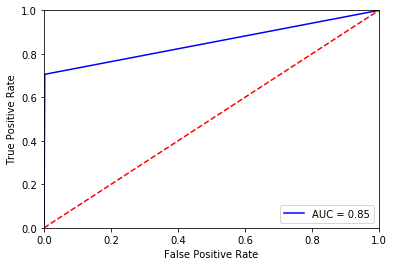

In [34]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_test.values[:, 0], y_pred)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Register fitted model for deployment

Now that we have a model we're happy with, we register it to our Azure ML account. This will be the first step toward model management and deployment, which we cover in the next Notebook. Registered models can also be loaded into other workspaces.

In [35]:
description = 'automated ML PdM (predict y_1)'
tags = None
model = local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azur

Registering model AutoMLa03293e16best


'AutoMLa03293e16best'

Optionally, we can also take the model and save it on disk as a pickle file, as shown here:

In [36]:
from sklearn.externals import joblib
joblib.dump(value=fitted_model, filename='model.pkl')

['model.pkl']

### Hands-on lab

<div class="alert alert-info">
So far we used automated ML to automatically train a classification model for only one of the four failure types, namely `y_1`. Write a loop to use automated ML to train, score and evaluate and finally register a classification model for `y_2`, `y_3` and `y_4`. In each case, compare the evaluation metrics we obtain to the ones we obtained in the previous Notebook when we hand-trained a model.
</div>

In [37]:
# all_output = {'y_1': {'local_run': local_run, 'model': model, 'cl_report': cl_report}}

# for i in range(1, 4): ## loop over each target class
#     print("Running automl on y_" + str(i+1))
#     ## YOUR CODE GOES HERE (modify the config file to point to the right target class)
#     ## YOUR CODE GOES HERE (submit the automated ML experiment)
#     ## YOUR CODE GOES HERE (extract the best model)
#     ## YOUR CODE GOES HERE (predict on the test data)
#     ## YOUR CODE GOES HERE (find the classification report for the best model and add it to y_report)
#     ## YOUR CODE GOES HERE (add results to all_output)
#     ## YOUR CODE GOES HERE (register the final model)

In [38]:
# %load ../solutions/automl_loop.py
all_output = {'y_1': {'local_run': local_run, 'model': model, 'cl_report': cl_report}}

for i in range(1, 4): ## loop over each target class
    print("Running automl on y_" + str(i+1))
    automl_config.fit_params.update({'y': y_train.values[:, i]})
    local_run = experiment.submit(automl_config, show_output=True)
    best_run, fitted_model = local_run.get_output()
    y_pred = fitted_model.predict(X_test)
    cl_report = classification_report(y_test.values[:, i], y_pred)
    print(cl_report)
    all_output['y_' + str(i+1)] = {'local_run': local_run, 'cl_report': cl_report}
    description = 'autometed ML PdM (predict y_{})'.format(str(i+1))
    model = local_run.register_model(description=description, tags=None)

Running automl on y_2
Parent Run ID: AutoML_fc2883b6-d432-456c-a9f3-e6beb99c7da1
***********************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
***********************************************************************************************

 ITERATION     PIPELINE                               DURATION                METRIC      BEST
         0      MaxAbsScaler LightGBMClassifier       0:00:13.454470           0.992     0.992
         1      RobustScaler GradientBoostingClassifie0:01:10.195047           0.988     0.992
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     61610
          1       0.90      0.10      0.18       990

avg / total       0.98 

<div class="alert alert-info">
NOTE: We can use automated ML to directly train a multi-class classification model instead of training many binary classification models. We will explore that in another Notebook.
</div>

### End of lab

In [39]:
all_output

{'y_1': {'local_run': Run(Experiment: pred-maint-automl,
  Id: AutoML_a03293e1-66be-4d2e-8960-6d89f51dcef6,
  Type: automl,
  Status: Completed),
  'model': <azureml.core.model.Model at 0x7fa7ee2ef4a8>,
  'cl_report': '             precision    recall  f1-score   support\n\n          0       1.00      1.00      1.00     62022\n          1       0.77      0.71      0.74       578\n\navg / total       1.00      1.00      1.00     62600\n'},
 'y_2': {'local_run': Run(Experiment: pred-maint-automl,
  Id: AutoML_fc2883b6-d432-456c-a9f3-e6beb99c7da1,
  Type: automl,
  Status: Completed),
  'cl_report': '             precision    recall  f1-score   support\n\n          0       0.99      1.00      0.99     61610\n          1       0.90      0.10      0.18       990\n\navg / total       0.98      0.99      0.98     62600\n'},
 'y_3': {'local_run': Run(Experiment: pred-maint-automl,
  Id: AutoML_ca96c11f-c713-4574-9b1b-9ea72d506a44,
  Type: automl,
  Status: Completed),
  'cl_report': '         

# The end

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.